# Predict auction price

Try several models and improve predicition accuracy

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns

In [2]:
matplotlib.rcParams['font.sans-serif'] = ['Helvetica','Arial', 'sans-serif']
matplotlib.rcParams['axes.titlesize'] = 24
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 24
matplotlib.rcParams['ytick.labelsize'] = 24
matplotlib.rcParams['figure.titlesize'] = 24
matplotlib.rcParams['font.size'] = 18

In [3]:
fn = '../data/cars-for-ml.pkl'
print(fn)
df = pd.read_pickle(fn)
print(df.columns)

# cetegories
cat_columns = ['brand', 'model', 'fuel', 'body_type','color']
print(list(df[cat_columns]))


../data/cars-for-ml.pkl
Index(['price', 'brand', 'model', 'age', 'fuel', 'odometer',
       'days_since_inspection_invalid', 'age_at_import', 'body_type',
       'displacement', 'number_of_cylinders', 'power', 'power2', 'weight',
       'registration_tax', 'sale_price', 'number_of_seats', 'number_of_doors',
       'color'],
      dtype='object')
['brand', 'model', 'fuel', 'body_type', 'color']


In [4]:
models = dict()

- - - - - 
# Model 1: Simple linear fit
Regress age (in days) with price (euro).  
!! Use all data, do not split train and test. !!   
!! Accuracy is based on data that was used for fit. !!

## Prepare input

In [5]:
from sklearn import linear_model

model_name = 'linear regression no cv'
betas = list()

X = df.dropna(subset=['price','age']).age.values.reshape(-1,1)
y = df.dropna(subset=['price','age']).price.values.reshape(-1,1)
print(X.shape)
print(y.shape)

(2883, 1)
(2883, 1)


## Fit

In [6]:
models[model_name] = dict()

# create regression model object and store
reg = linear_model.LinearRegression()
models[model_name].update({'model':reg})

# fit
reg.fit(X,y)
models[model_name].update({'n':y.shape[0]})

# parameters
betas.append([*reg.intercept_, *reg.coef_[0]])
models[model_name].update({'betas':betas})

# score
models[model_name].update({'R^2':reg.score(X,y)})

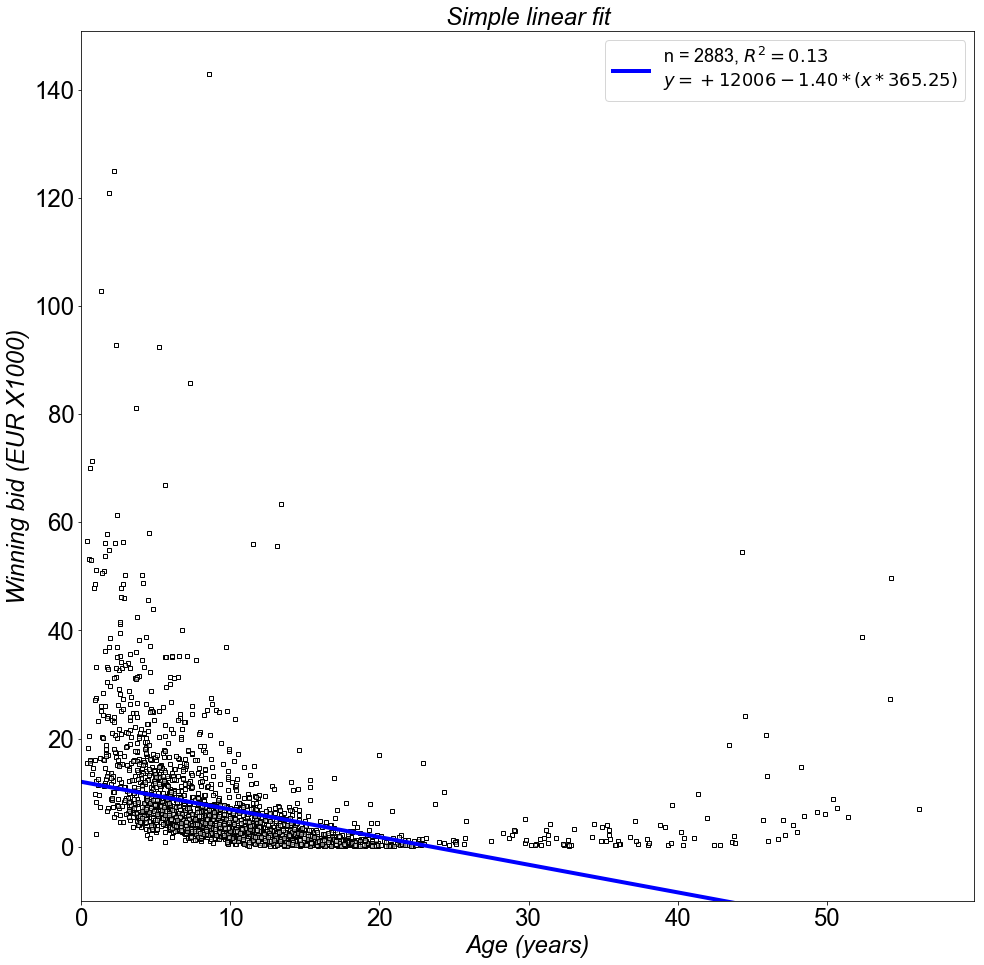

In [7]:
# Fit a line by using predict
prediction_X = pd.np.array([0,int(pd.np.ceil(X.max()/365.25))*365.25]).reshape(-1,1)
prediction_y = reg.predict(prediction_X)

# plot
plt.figure(figsize=[16,16])
plt.plot(X/365.25, y/1000, marker='s', markeredgecolor = (0, 0, 0, 1), markerfacecolor = (1, 1, 1, .5), linestyle='None', ms=4)
hdl_fit = plt.plot(prediction_X/365, prediction_y/1000, color='blue', marker=None, linestyle='-', linewidth=4)
plt.legend(hdl_fit, ['n = {}, $R^2 = {:.2f}$\n$y = {:+.0f}{:+.2f}*(x*365.25)$'.format(
    models[model_name]['n'],
    models[model_name]['R^2'],
    *models[model_name]['betas'][-1]
)], loc='upper right')
plt.xlabel('Age (years)', style='italic')
plt.ylabel('Winning bid (EUR X1000)', style='italic')
plt.title('Simple linear fit', style='italic')
plt.ylim(bottom = -10)
plt.xlim(left = 0)

plt.savefig('../results/{}.png'.format(model_name.replace(' ','_')), bbox_inches='tight', transparent=True)